# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


In [1]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
!python -V ## added
from nltk.corpus import brown
import nltk ## addded
nltk.download('brown') ## addded

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

#!pip install spacy -q ## addded
#!python -m spacy download en_core_web_sm -q ## addded
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

Python 3.9.7


[nltk_data] Downloading package brown to
[nltk_data]     /Users/halledavis/nltk_data...
[nltk_data]   Package brown is already up-to-date!
/Users/halledavis/opt/anaconda3/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:205: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
/Users/halledavis/opt/anaconda3/lib/python3.9/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:326: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
Using TensorFlow backend.
/Users/halledavis/opt/anaconda3/lib/python3.9/site-packages/keras/callbacks.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [2]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [3]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [4]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [5]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


In [6]:
df

,category,id,text,char_len,word_len
0,editorial,cb01,Assembly session brought much good The General...,12659,2200
1,editorial,cb02,Must Berlin remain divided ? ? The inference h...,12544,2234
2,editorial,cb03,"A good man departs . Goodby , Mr. Sam . Sam Ra...",11871,2244
3,editorial,cb04,A shock wave from Africa Word of Dag Hammarskj...,12284,2230
4,editorial,cb05,Help when needed If the Dominican Republic ach...,12479,2241
...,...,...,...,...,...
161,hobbies,ce32,"Throughout history , the man who showed superi...",13629,2339
162,hobbies,ce33,Sixty miles north of New York City where the w...,11845,2233
163,hobbies,ce34,"In the period since the end of World War 2 , -...",13029,2300
164,hobbies,ce35,New rule no. 2 : : Don't build from the outsid...,11800,2272


<AxesSubplot: xlabel='category'>

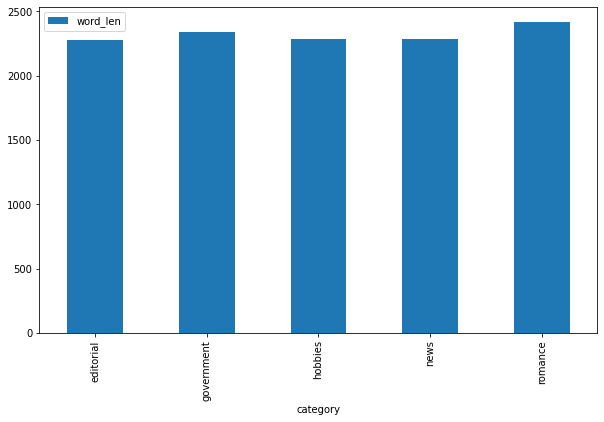

In [7]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [8]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/Users/halledavis/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [9]:
count_text_vectors

<166x4941 sparse matrix of type '<class 'numpy.int64'>'
	with 72541 stored elements in Compressed Sparse Row format>

In [10]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

In [11]:
tfidf_text_vectors

<166x4941 sparse matrix of type '<class 'numpy.float64'>'
	with 72541 stored elements in Compressed Sparse Row format>

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: Both are sparse document term matrixes where the columns are words from the corpus and the rows are documents in the corpus. They differ in that the count_text_vectors matrix's values/elements is simply the frequency of how much the word shows up in the document; whereas tfidf_text_vector's values/elements is both frequency and importance of the words.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [12]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [13]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [14]:
# Let's go document by document and make a list of brown categories by topic
topic_to_category = defaultdict(list)
for idx, row in enumerate(W_text_matrix) : 
    topic = np.where(row == np.amax(row))[0]
    category = df["category"].iloc[idx]
    
    topic_to_category[topic[0]].append(category)

In [15]:
topic_to_category

defaultdict(list,
            {2: ['editorial',
              'editorial',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government',
              'news',
              'news',
              'news',
              'news',
              'news',
              'news',
              'news',
              'news',
              'news',

Q: How does your five-topic NMF model compare to the original Brown categories? 

A: Topic 0 is primarily editorial (20/32 documents).
Topic 1 is primarily romance (29/41) documents).
Topic 2 is basically half government (26 documents) half hobbies (27 documents).
Topic 3 is all news (except 1 doc).
Topic 4 is all news (except 2 docs).

So from what we're seeing the NMF documents generally are at least halfway associated with a Brown category and up to 90% similar. I think this is pretty homogenous/well representative of the original Brown categories.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [16]:
# Your code here

svd_para_model = TruncatedSVD(n_components = 5, random_state=314)
W_text_matrix = svd_para_model.fit_transform(tfidf_text_vectors)
H_text_matrix = svd_para_model.components_

In [17]:
topic_to_category = defaultdict(list)
for idx, row in enumerate(W_text_matrix) : 
    topic = np.where(row == np.amax(row))[0]
    category = df["category"].iloc[idx]
    
    topic_to_category[topic[0]].append(category)

In [18]:
topic_to_category

defaultdict(list,
            {0: ['editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government',
              'government'

Q: How does your five-topic LSA model compare to the original Brown categories? 

A:  Topic 0 is mix of editorial, government, news, and romance.
Topic 1 is all romance.
Topic 3 is all news.
Topic 4 is all news.

This didn't seem to match the brown categories as well -- Topics 1-4 don't have a lot of documents associated with them and Topic 0 is too broad.

In [19]:
# call display_topics on your model

display_topics(svd_para_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


Q: What is your interpretation of the display topics output? 

A: Lots of stop words should be removed, like said, mr, mrs. I think they are throwing off the analysis and broadening the topics to the point of being unimportant/unenlightening. Generally topic importance is also low. The only topic that seems worthwhile is topic 4 which is about sports, clearly.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [20]:
# Fit your LDA model here

lda_text_model = LatentDirichletAllocation(n_components = 5, random_state=314)
W_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_text_matrix = lda_text_model.components_

In [21]:
# Call `display_topics` on your fitted model here

display_topics(lda_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (1.05)
  mrs (0.82)
  little (0.56)
  good (0.51)
  way (0.50)

Topic 01
  state (0.67)
  development (0.63)
  000 (0.57)
  program (0.48)
  business (0.44)

Topic 02
  said (1.18)
  mr (0.72)
  president (0.51)
  city (0.43)
  state (0.37)

Topic 03
  feed (0.55)
  college (0.54)
  general (0.44)
  university (0.43)
  work (0.37)

Topic 04
  states (1.14)
  state (1.02)
  united (0.84)
  shall (0.66)
  government (0.61)


In [22]:
topic_to_category = defaultdict(list)
for idx, row in enumerate(W_text_matrix) : 
    topic = np.where(row == np.amax(row))[0]
    category = df["category"].iloc[idx]
    
    topic_to_category[topic[0]].append(category)

In [23]:
topic_to_category

defaultdict(list,
            {2: ['editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'editorial',
              'government',
              'government',
              'government',
              'news',
              'news',
              'news',
              'news',
              'news',
              'news',
              'news',
              'news',
              'news',
              'news',
              'news',
              'news',
              'news',
              'news',
              'news'

Q: What inference do you draw from the displayed topics for your LDA model? 

A: Lots of stop words should be removed, like said, mr, mrs. I think they are throwing off the analysis and broadening the topics to the point of being unimportant/unenlightening. Generally topic importance is also low. Topics 1, 2, and 4 seem newsish/political and topic 3 seems to be about school/work.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: Topic 0 is mix of editorial, government, news, and romance.
Topic 1 is all romance.
Topic 2 is all 
Topic 3 is all news.
Topic 4 is all news.

In [24]:
lda_display = pyLDAvis.lda_model.prepare(
    lda_text_model,
    count_text_vectors, count_text_vectorizer, sort_topics=False)

/Users/halledavis/opt/anaconda3/lib/python3.9/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/Users/halledavis/opt/anaconda3/lib/python3.9/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/Users/halledavis/opt/anaconda3/lib/python3.9/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/Users/halledavis/opt/anaconda3/lib/python3.9/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version inst

In [25]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: Our topics are distinct (there isn't a lot of overlap), but I would say topics 2 and 4 seem the most similar. Topic 3 is the broadest topic/the topic with the most distribtuion.